In [1]:
#  XSM lightcurve for 16:00UT 29 Aug 2022 flare
# 
# IGH 29-08-2023

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy import timeseries as ts
from sunpy.time import parse_time
from astropy.io import fits
import astropy.time as atime
import astropy.units as u
import datetime
import pandas as pd
import os
from pathlib import Path
import glob

import warnings
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
            'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [3]:
#  Load the data
xsmdir='/Users/iain/data/xsm/data/2022/08/29/calibrated/'
xsmfname=xsmdir+'ch2_xsm_20220829_v1_level2.lc'

hdulist = fits.open(xsmfname)
xdata=hdulist[1].data
xhdr=hdulist[1].header
hdulist.close()

In [4]:
# Put the data in a pandas dataframe
tr=[datetime.datetime(2022,8,29,16,0,0),datetime.datetime(2022,8,29,18,0,0)]

mjdref=atime.Time(xhdr['mjdref'],format='mjd')
xtims=atime.Time(mjdref+xdata['time']*u.s,format='mjd')
numrate=np.array(xdata["rate"])
rate=numrate.byteswap().newbyteorder()
err=np.array(xdata["error"])
xdf=pd.DataFrame(np.array([rate,err]).T,index=xtims.datetime, columns=['rate','error'])
xdf_tr=xdf.truncate(tr[0],tr[1])
xdfdata=xdf_tr["rate"].values

In [5]:
# 1s resolution..
print(xdf_tr.index[0:2])

DatetimeIndex(['2022-08-29 16:19:09.929465', '2022-08-29 16:19:10.929465'], dtype='datetime64[ns]', freq=None)


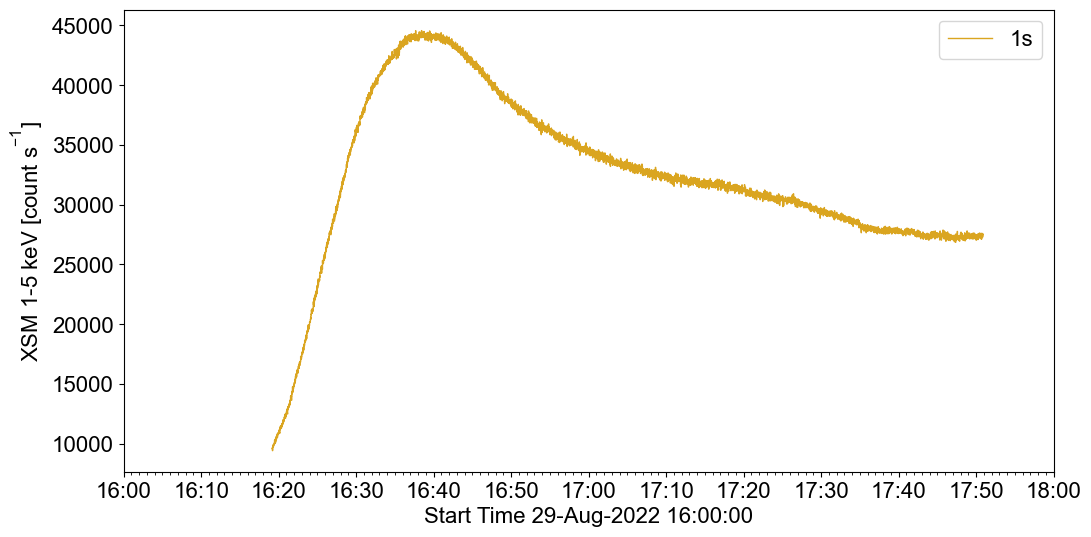

In [6]:
# Plot this level 2 calibrated 1s lightcurve for 1-15 keV

myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=1)
plt.rcParams.update({'font.size': 16})
fig, ax= plt.subplots(1,figsize=(12, 6))

ax.plot(xdf_tr.index, xdfdata,drawstyle='steps-post',marker=None,\
            color='goldenrod',lw=1,label='1s') 
# ax.errorbar(xdf_tr.index, xdfdata,yerr=xdf_tr['error'].values,drawstyle='steps-post',marker=None,\
#             color='goldenrod',lw=1,label='1s') 
ax.set_xlim(tr)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(f'Start Time {tr[0]:%d-%b-%Y %H:%M:%S}')
ax.set_ylabel('XSM 1-5 keV [count s$^{-1}$]')
ax.legend()
plt.show()

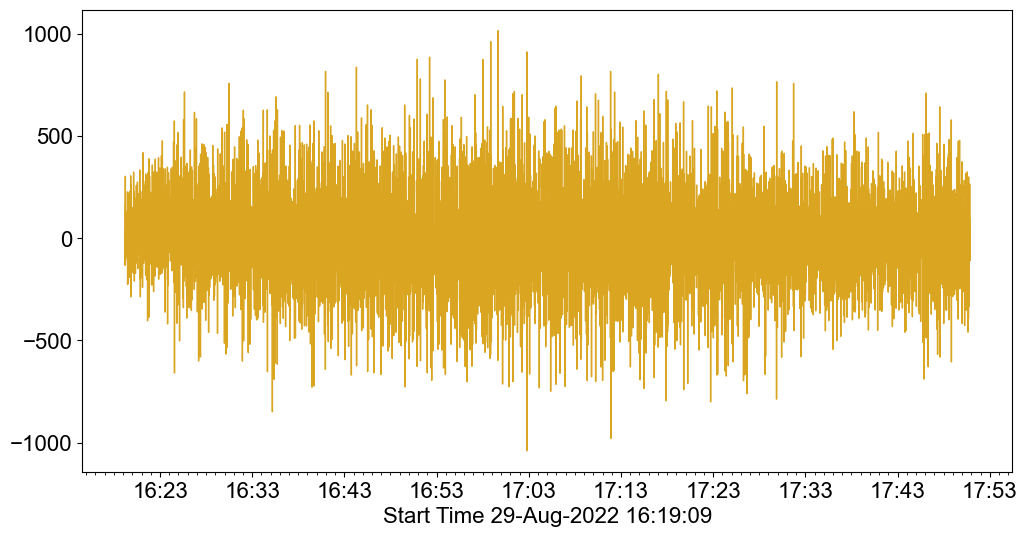

In [7]:
#  Anythin in the derivative plot?
deriv=xdfdata[1:]-xdfdata[0:-1]
fig, ax= plt.subplots(1,figsize=(12, 6))

ax.plot(xdf_tr.index[:-1], deriv,drawstyle='steps-post',marker=None,\
            color='goldenrod',lw=1,label='XSM 1-15') 
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(f'Start Time {xdf_tr.index[0]:%d-%b-%Y %H:%M:%S}')
plt.show()

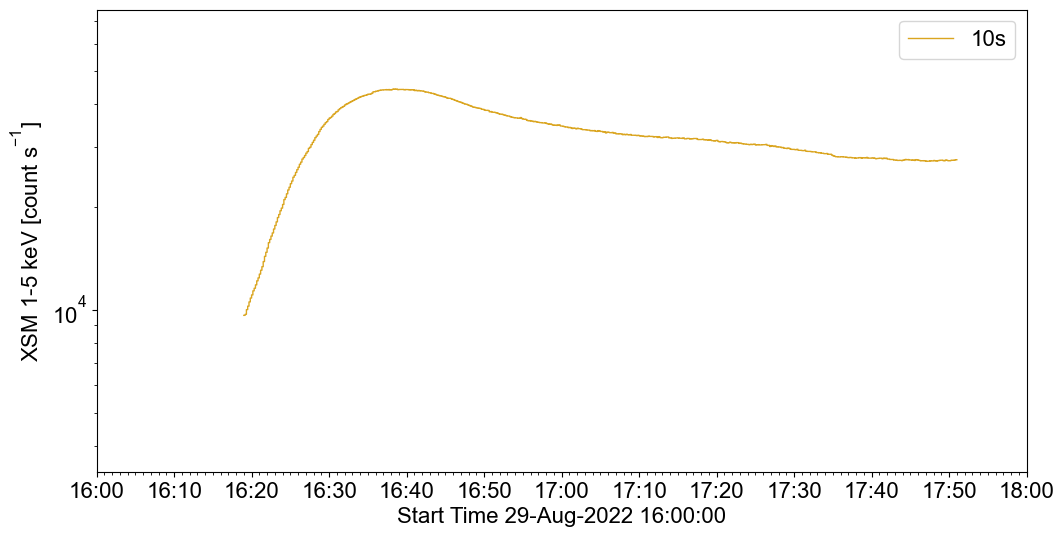

In [8]:
# Resample to 10s and plot y log

xdf10=xdf.resample('10s', level=0).mean()

myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=1)
plt.rcParams.update({'font.size': 16})
fig, ax= plt.subplots(1,figsize=(12, 6))

# ax.errorbar(xdf10.index, xdf10['rate'].values,yerr=xdf10['error'].values,drawstyle='steps-post',marker=None,\
#             color='goldenrod',lw=1,label='10s') 
ax.plot(xdf10.index, xdf10['rate'].values,drawstyle='steps-post',marker=None,\
            color='goldenrod',lw=1,label='10s') 
ax.set_xlim(tr)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.set_yscale('log')
ax.set_xlabel(f'Start Time {tr[0]:%d-%b-%Y %H:%M:%S}')
ax.set_ylabel('XSM 1-5 keV [count s$^{-1}$]')
ax.legend()
plt.show()

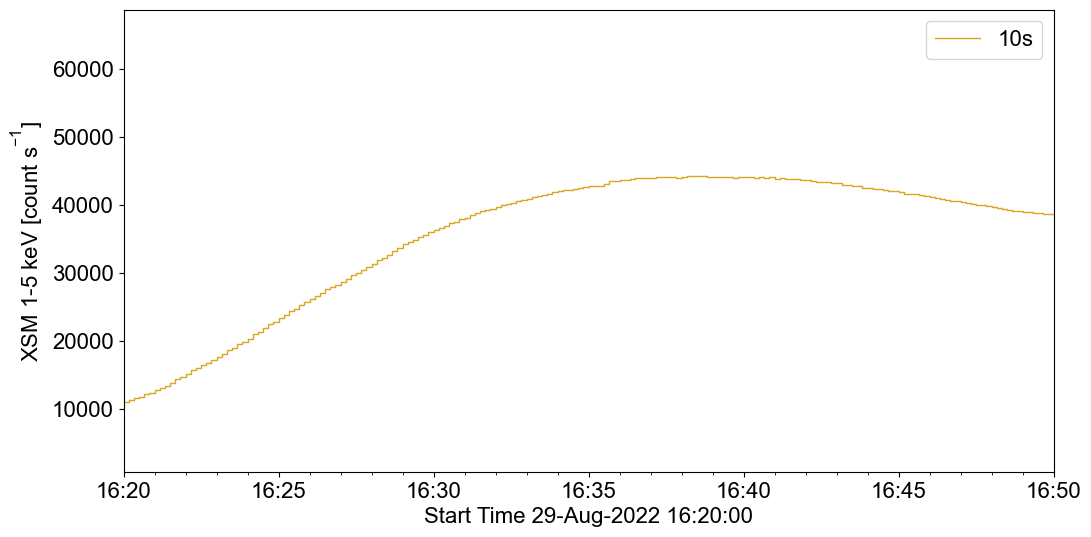

In [9]:
# Zoom in on peak in 10s lightcurve

myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=10)
minorx= matplotlib.dates.MinuteLocator(interval=1)
plt.rcParams.update({'font.size': 16})
fig, ax= plt.subplots(1,figsize=(12, 6))

ax.plot(xdf10.index, xdf10['rate'].values,drawstyle='steps-post',marker=None,\
            color='goldenrod',lw=1,label='10s') 
ax.set_xlim(datetime.datetime(2022,8,29,16,20,0),datetime.datetime(2022,8,29,16,50,0))
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=5))
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(f'Start Time {datetime.datetime(2022,8,29,16,20,0):%d-%b-%Y %H:%M:%S}')
ax.set_ylabel('XSM 1-5 keV [count s$^{-1}$]')
ax.legend()
plt.show()

In [10]:
#  try adding in the spectra to see what it's doing

In [11]:
# Load in level 2 calibrated pha file
xsmfpha=xsmdir+'ch2_xsm_20220829_v1_level2.pha'

hdul = fits.open(xsmfpha)
phadata = hdul[1].data
phahdr = hdul[0].header
hdul.close()
#  This processing is 1 min spectra in 512 channels, each 33 eV
tstop=atime.Time(mjdref+phadata['tstop']*u.s,format='mjd')
tstart=atime.Time(mjdref+phadata['tstart']*u.s,format='mjd')
expos=phadata['exposure']
counts=phadata['counts']  



# ('SPEC_NUM', '>i4'), ('CHANNEL', '>i4', (512,)), ('COUNTS', '>f4', (512,)), ('STAT_ERR', '>f4', (512,)), 
# ('SYS_ERR', '>f4', (512,)), ('EXPOSURE', '>f8'), ('TSTART', '>f8'), ('TSTOP', '>f8'), ('FILT_STATUS', 'u1')]))

In [12]:
# This is the gain corrected 512 channel PI spectrum from the raw 1024
# from caldb ebins file
# Energy range: 0.5-17.396 keV. Binsize: 33.0 eV
engs=0.5+phadata['channel'][0]*0.033

2022-08-29 16:37:00.930365 2022-08-29 16:38:00.930365


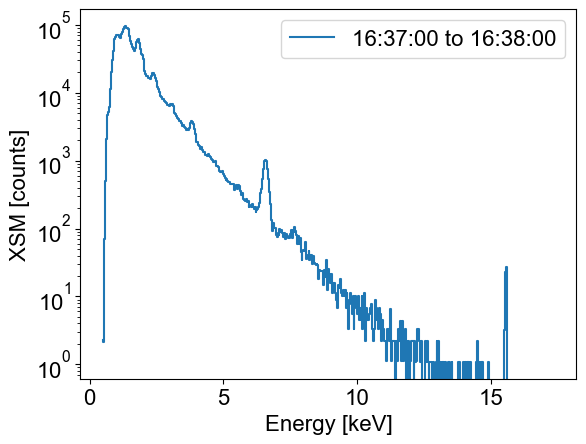

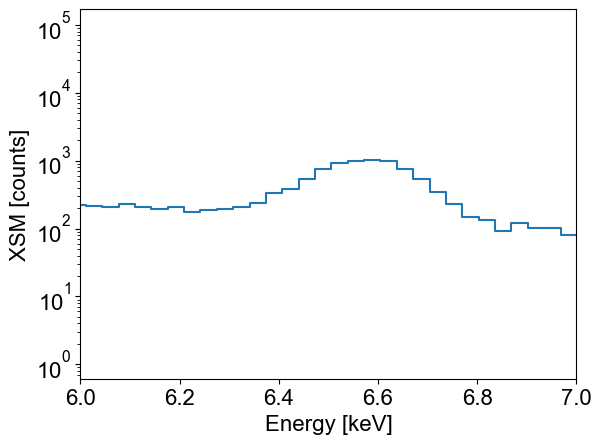

In [13]:
#  Plot a spectrum near the peak time.....
print(tstart[720].datetime,tstop[720].datetime)

plt.step(engs,counts[720],where='pre',\
         label=f'{tstart[720].datetime:%H:%M:%S} to {tstop[720].datetime:%H:%M:%S}')
plt.ylabel('XSM [counts]')
plt.xlabel('Energy [keV]')
plt.yscale('log')
plt.legend()
plt.show()

# Just check Fe k-shell is where it should be
plt.step(engs,counts[720],where='pre')
plt.ylabel('XSM [counts]')
plt.xlabel('Energy [keV]')
plt.xlim([6,7])
plt.yscale('log')
plt.show()

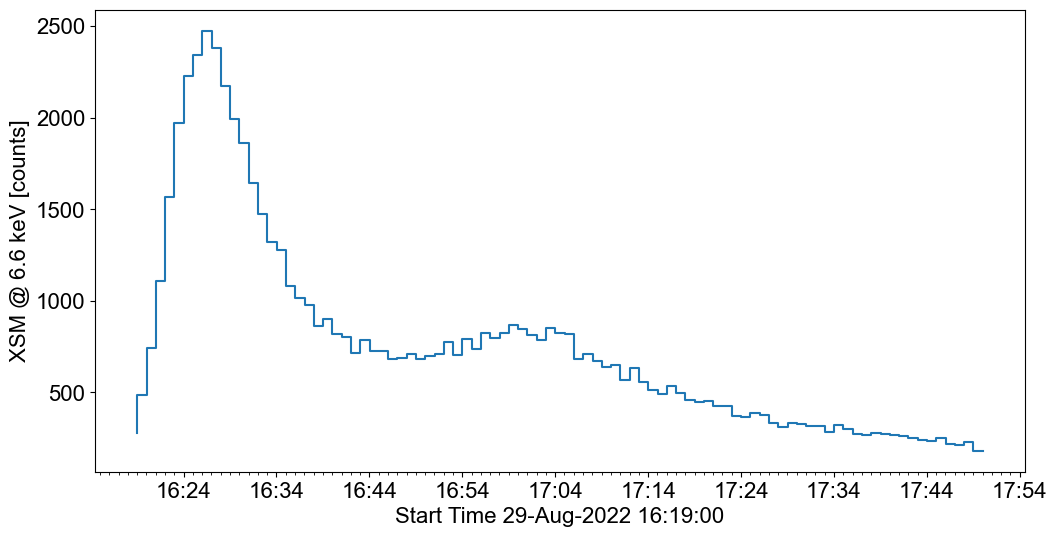

In [14]:
# Let's make a light curve @ 6.6 keV
id=185
xdf66=pd.DataFrame(counts[:,id],index=tstart.datetime, columns=['counts'])
xdf66_tr=xdf66.truncate(tr[0],tr[1])

fig, ax= plt.subplots(1,figsize=(12, 6))

ax.step(xdf66_tr.index,xdf66_tr['counts'].values,where='pre')
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel(f'Start Time {xdf66_tr.index[0]:%d-%b-%Y %H:%M:%S}')
ax.set_ylabel(f'XSM @ {engs[id]:.2} keV [counts]')
plt.show()
